In [33]:
!pip install statsmodels


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [83]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.stats.diagnostic as diag
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
import os

In [9]:
# Load dataset
os.chdir("D:\Data_Science_ML_IITR_Sem_3\datasets")
data = pd.read_csv("tips (data for regression problem).csv")
data

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [10]:
data.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


In [11]:
data.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

In [12]:
t = data["time"].unique()
s = data["sex"].unique()
d = data["day"].unique()
sm = data["smoker"].unique()
print("time", t)
print("sex", s)
print("day", d)
print("smoker", sm)

time ['Dinner' 'Lunch']
sex ['Female' 'Male']
day ['Sun' 'Sat' 'Thur' 'Fri']
smoker ['No' 'Yes']


In [13]:
data_encoded = data.copy()

label_encoder = LabelEncoder()

# Loop over each column and apply LabelEncoder if column type is 'object' (categorical)
for column in data_encoded.select_dtypes(include=['object']).columns:
    data_encoded[column] = label_encoder.fit_transform(data_encoded[column])

data_encoded.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,0,0,2,0,2
1,10.34,1.66,1,0,2,0,3
2,21.01,3.50,1,0,2,0,3
3,23.68,3.31,1,0,2,0,2
4,24.59,3.61,0,0,2,0,4


Time = 0 : Dinner, 1 : Lunch

Sex = 0 : Female, 1 : Male

Smoker = 0 : No, 1 : Yes

Day = 0 : Fri, 1 : Sat, 2 : Sun, 3 : Thur

## Scatter PLots of 'Tip' vs Other Features

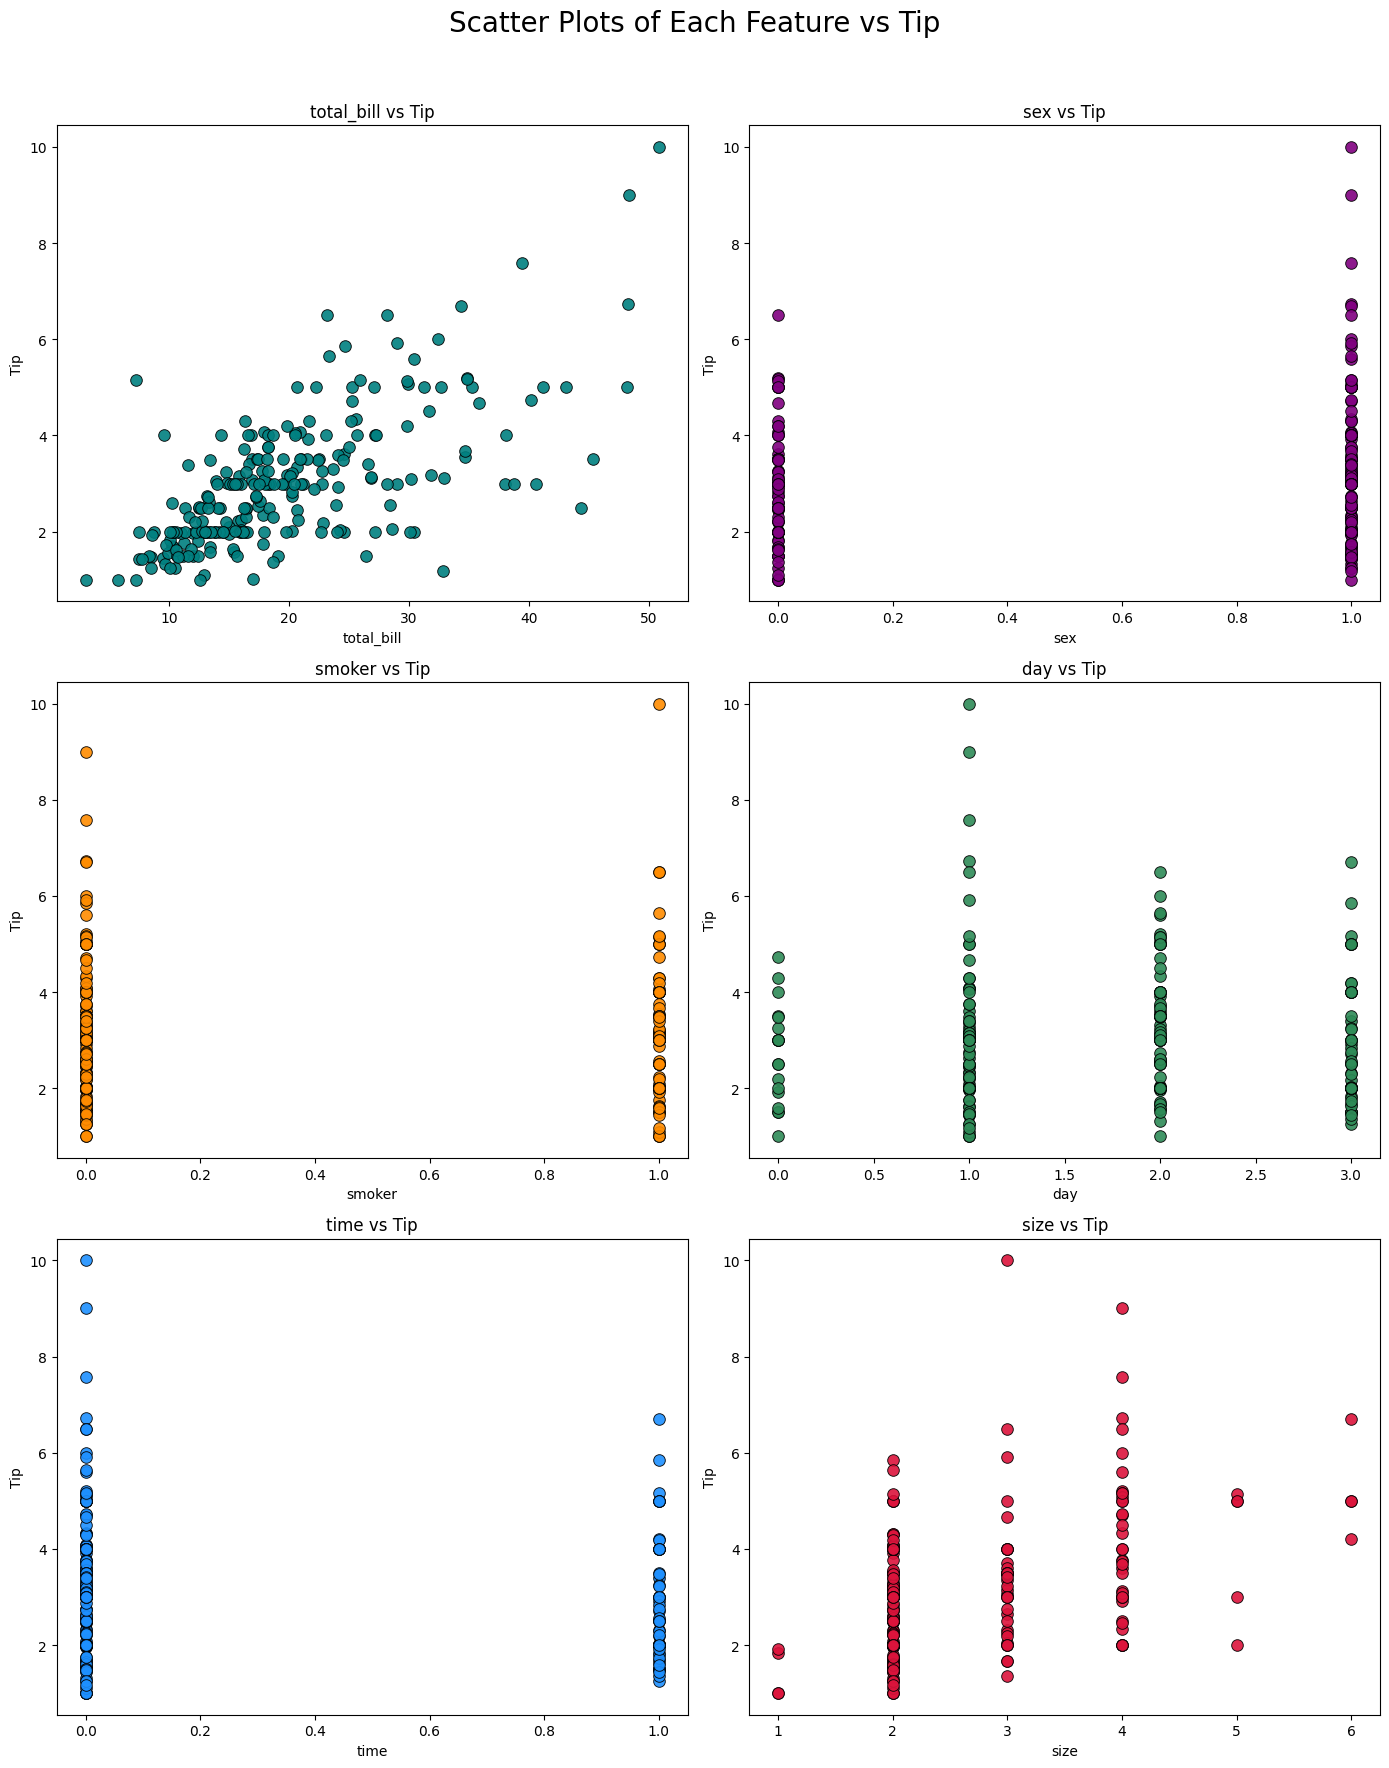

In [29]:
columns_to_plot = data_encoded.columns.drop('tip')

# Define a color palette for different colors for each plot
colors = ['teal', 'purple', 'darkorange', 'seagreen', 'dodgerblue', 'crimson', 'gold', 'navy']

# Create subplots for each column vs 'tip' with 2 columns per row
n_cols = 2
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols  # Calculate rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))
fig.suptitle("Scatter Plots of Each Feature vs Tip", fontsize=20)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Loop through each column and create a scatter plot with a unique color
for i, column in enumerate(columns_to_plot):
    sns.scatterplot(
        x=data_encoded[column], y=data_encoded['tip'], 
        ax=axes[i], color=colors[i % len(colors)], s=70, alpha=0.9, edgecolor='k'
    )
    axes[i].set_title(f'{column} vs Tip')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Tip')

# Remove any unused subplots if columns_to_plot is not a perfect multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show the plots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for the main title
plt.show()

## Correlation matrix (Heat Map)

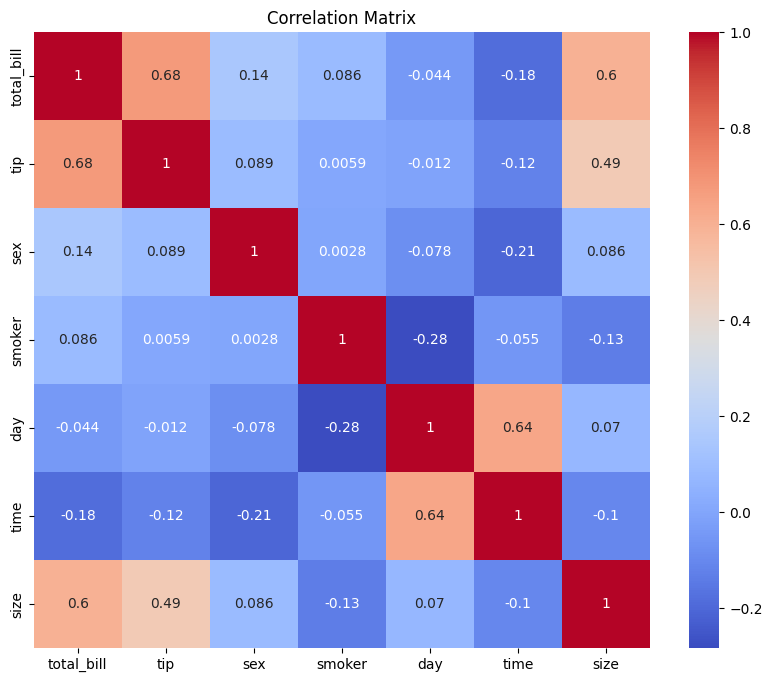

In [16]:
# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data_encoded.corr(), annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

## Correlation between (Total Bill and Tip) and (Size and Tip)

In [30]:
# Calculate correlation between 'tip' and 'total_bill'
correlation_tip_total_bill = data['tip'].corr(data['total_bill'])
print(f"Correlation between Tip and Total Bill: {correlation_tip_total_bill:.2f}")

# Calculate correlation between 'tip' and 'size'
correlation_tip_size = data['tip'].corr(data['size'])
print(f"Correlation between Tip and Size: {correlation_tip_size:.2f}")


Correlation between Tip and Total Bill: 0.68
Correlation between Tip and Size: 0.49


#### --> Higher Positive Value of Correlation between Total Bill and Tip suggests significant Positive Linear Dependence of Tip on Total Bill.
#### --> 0.5 Correlation between tip and size shows low positive correlation (linear dependence) between them.

## Pair plot for relationships among variables

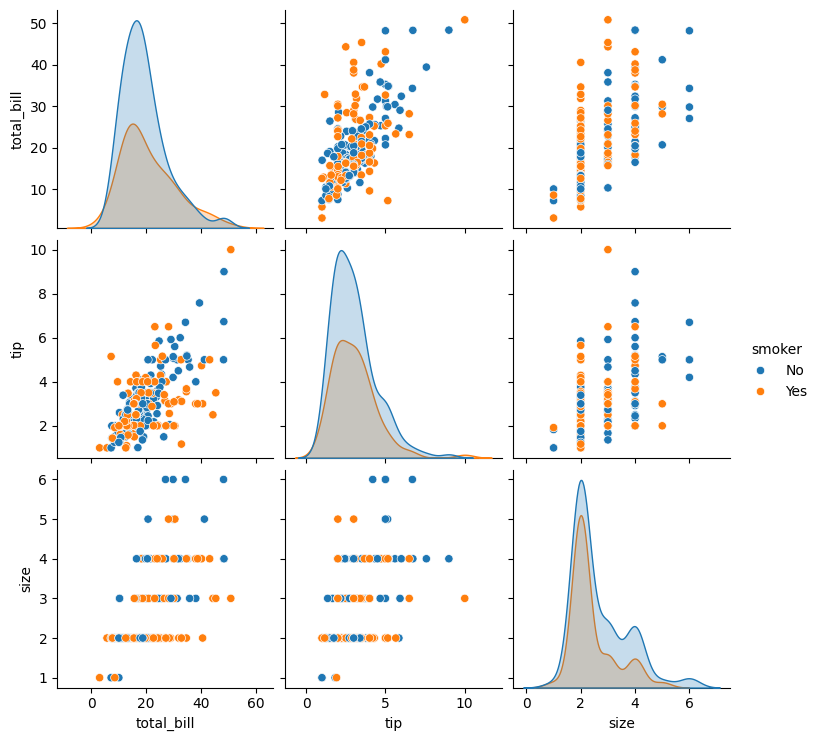

In [17]:
sns.pairplot(data, hue='smoker')
plt.show()

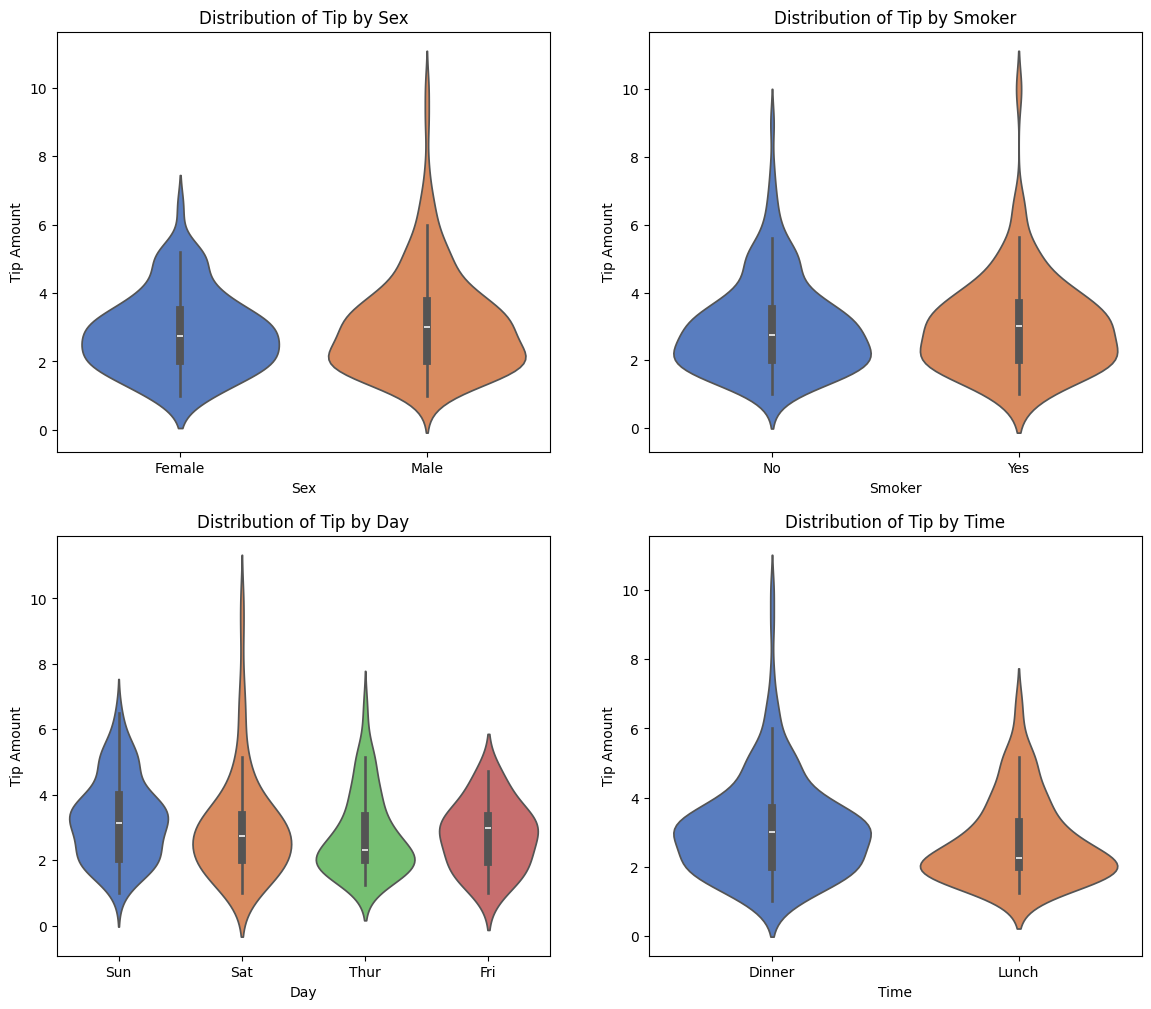

In [18]:
categorical_columns = ['sex', 'smoker', 'day', 'time']

# Set up the figure for 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Loop over the categorical columns and create a violin plot for each
for i, cat in enumerate(categorical_columns):
    ax = axes[i // 2, i % 2]  # Select the appropriate subplot
    sns.violinplot(x=cat, y="tip", data=data, ax=ax, palette='muted')
    
    # Customize the plot
    ax.set_title(f"Distribution of Tip by {cat.capitalize()}")
    ax.set_xlabel(cat.capitalize())
    ax.set_ylabel("Tip Amount")

# Adjust layout for better spacing
plt.tight_layout
plt.show()

## Rainbow Test for linearity

In [36]:
X_rainbow = data[['total_bill']]
y_rainbow = data['tip']
rainbow_stat, p_value = diag.linear_rainbow(sm.OLS(y_rainbow, sm.add_constant(X_rainbow)).fit())
print(f'Rainbow test statistic: {rainbow_stat}')
print(f'p-value: {p_value}')

Rainbow test statistic: 1.229148022612903
p-value: 0.12911921525513964


#### The p-value is large enough (>> 0.05) to suggest that Linear Model/Linear Regression fit between Total Bill and Tip is appropriate. And that non-linear model is not needed.

## Line Plot of Total Bill and Size vs Tip

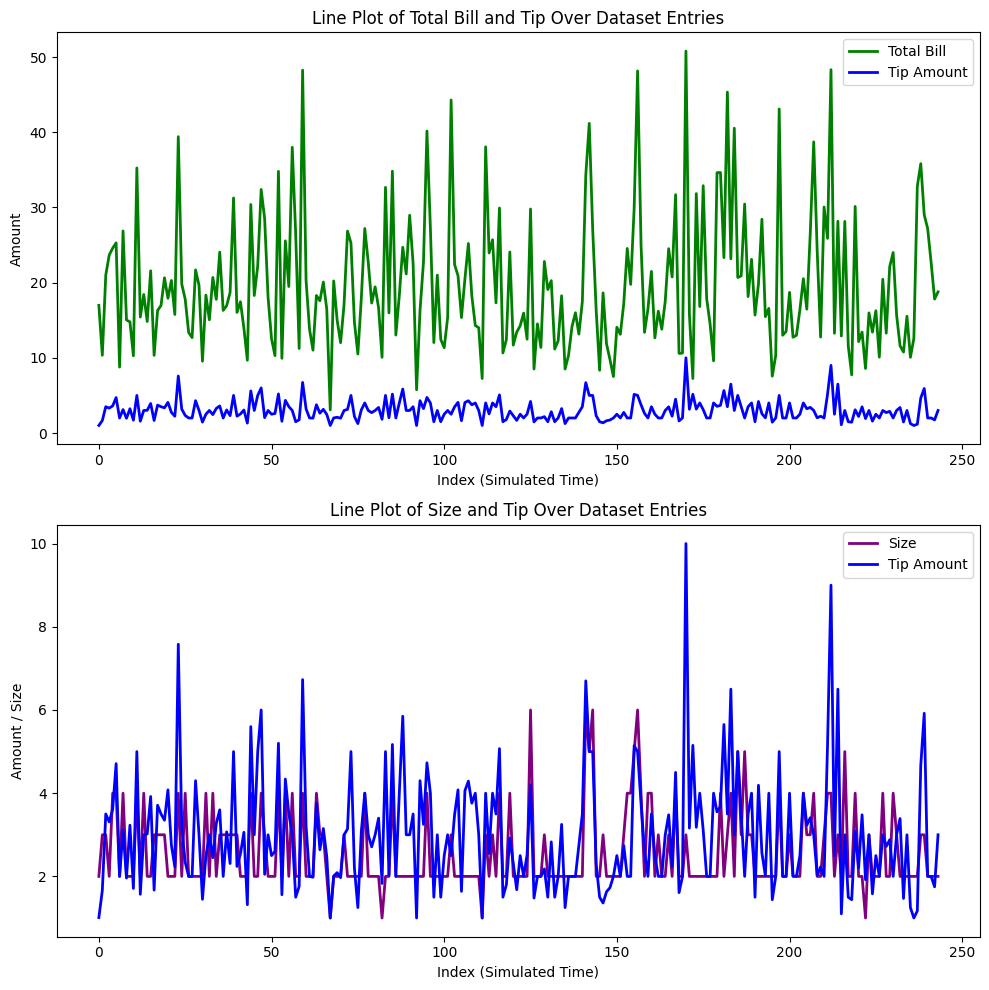

In [64]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Line plot for 'total_bill' vs 'tip'
axes[0].plot(data.index, data['total_bill'], color='green', label='Total Bill', linewidth=2)
axes[0].plot(data.index, data['tip'], color='blue', label='Tip Amount', linewidth=2)
axes[0].set_title("Line Plot of Total Bill and Tip Over Dataset Entries")
axes[0].set_xlabel("Index (Simulated Time)")
axes[0].set_ylabel("Amount")
axes[0].legend()

# Line plot for 'size' vs 'tip'
axes[1].plot(data.index, data['size'], color='purple', label='Size', linewidth=2)
axes[1].plot(data.index, data['tip'], color='blue', label='Tip Amount', linewidth=2)
axes[1].set_title("Line Plot of Size and Tip Over Dataset Entries")
axes[1].set_xlabel("Index (Simulated Time)")
axes[1].set_ylabel("Amount / Size")
axes[1].legend()

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

## Line plot for Categorical Features vs Tip amount

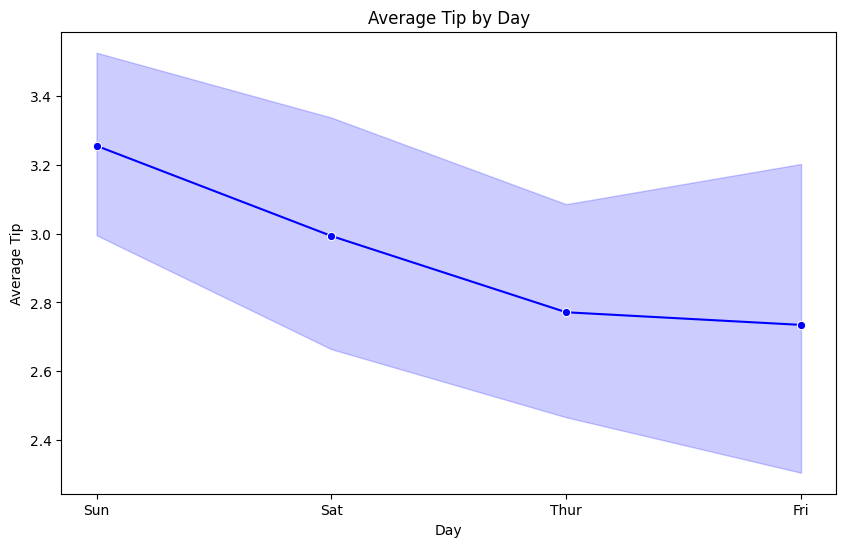

In [77]:
# Line plot for average tip by day
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x="day", y="tip", estimator="mean", marker="o", color='blue')
plt.title("Average Tip by Day")
plt.xlabel("Day")
plt.ylabel("Average Tip")
plt.show()

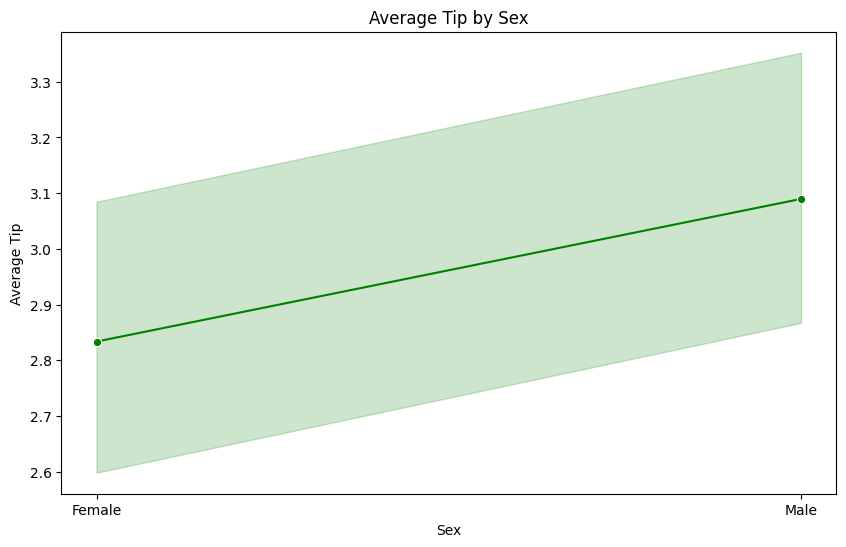

In [78]:
# Line plot for average tip by sex
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x="sex", y="tip", estimator="mean", marker="o", color='green')
plt.title("Average Tip by Sex")
plt.xlabel("Sex")
plt.ylabel("Average Tip")
plt.show()

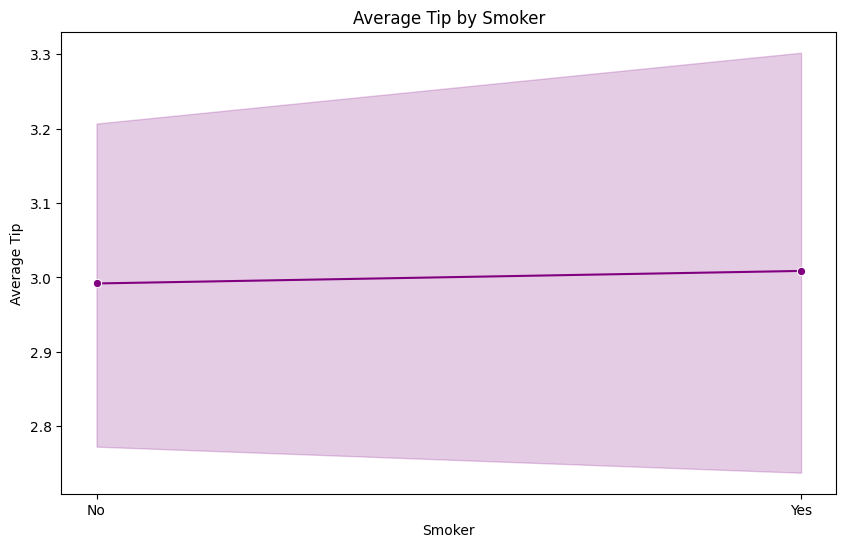

In [79]:
# Line plot for average tip by smoker
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x="smoker", y="tip", estimator="mean", marker="o", color='purple')
plt.title("Average Tip by Smoker")
plt.xlabel("Smoker")
plt.ylabel("Average Tip")
plt.show()

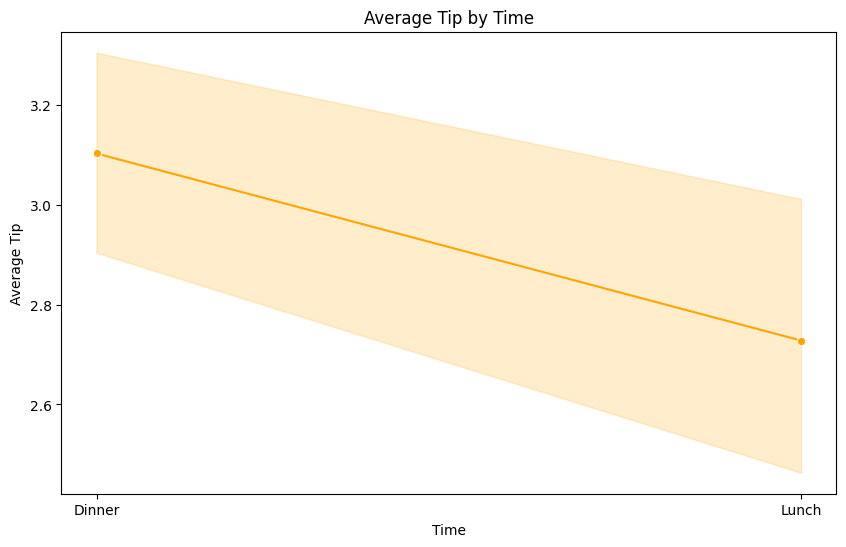

In [80]:
# Line plot for average tip by time (lunch/dinner)
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x="time", y="tip", estimator="mean", marker="o", color='orange')
plt.title("Average Tip by Time")
plt.xlabel("Time")
plt.ylabel("Average Tip")
plt.show()

# Applying Regression Methods

In [40]:
# Standardize numerical features for models like SVR and KNN
scaler = StandardScaler()
data_encoded[['total_bill', 'size']] = scaler.fit_transform(data_encoded[['total_bill', 'size']])

# Split data into features and target variable
X = data_encoded.drop('tip', axis=1)
y = data_encoded['tip']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Linear Regression

In [41]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

# Performance
print(f"Linear Regression - MSE: {mean_squared_error(y_test, y_pred_lr)}, R²: {r2_score(y_test, y_pred_lr)}")

Linear Regression - MSE: 0.6948129686287682, R²: 0.4441368826121954


## Ridge and Lasso Regression with Grid Search

In [42]:
# Ridge Regression with Grid Search
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_reg = Ridge()
ridge_grid = GridSearchCV(ridge_reg, ridge_params, cv=5, scoring='r2')
ridge_grid.fit(X_train, y_train)
y_pred_ridge = ridge_grid.predict(X_test)
print("Best Ridge alpha:", ridge_grid.best_params_)
print(f"Ridge Regression - MSE: {mean_squared_error(y_test, y_pred_ridge)}, R²: {r2_score(y_test, y_pred_ridge)}")

# Lasso Regression with Grid Search
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_reg = Lasso()
lasso_grid = GridSearchCV(lasso_reg, lasso_params, cv=5, scoring='r2')
lasso_grid.fit(X_train, y_train)
y_pred_lasso = lasso_grid.predict(X_test)
print("Best Lasso alpha:", lasso_grid.best_params_)
print(f"Lasso Regression - MSE: {mean_squared_error(y_test, y_pred_lasso)}, R²: {r2_score(y_test, y_pred_lasso)}")

Best Ridge alpha: {'alpha': 10}
Ridge Regression - MSE: 0.6804514484394094, R²: 0.4556263621460037
Best Lasso alpha: {'alpha': 0.1}
Lasso Regression - MSE: 0.6121051239307194, R²: 0.5103046751866708


## Decision Tree Regression with Hyperparameter Tuning

In [43]:
tree_params = {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]}
tree_reg = DecisionTreeRegressor(random_state=42)
tree_grid = GridSearchCV(tree_reg, tree_params, cv=5, scoring='r2')
tree_grid.fit(X_train, y_train)
y_pred_tree = tree_grid.predict(X_test)
print("Best Decision Tree params:", tree_grid.best_params_)
print(f"Decision Tree - MSE: {mean_squared_error(y_test, y_pred_tree)}, R²: {r2_score(y_test, y_pred_tree)}")

Best Decision Tree params: {'max_depth': 3, 'min_samples_split': 2}
Decision Tree - MSE: 0.7804343720990292, R²: 0.375638189586897


## Random Forest Regression with Hyperparameter Tuning

In [44]:
forest_params = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, None]}
forest_reg = RandomForestRegressor(random_state=42)
forest_grid = GridSearchCV(forest_reg, forest_params, cv=5, scoring='r2')
forest_grid.fit(X_train, y_train)
y_pred_forest = forest_grid.predict(X_test)
print("Best Random Forest params:", forest_grid.best_params_)
print(f"Random Forest - MSE: {mean_squared_error(y_test, y_pred_forest)}, R²: {r2_score(y_test, y_pred_forest)}")

Best Random Forest params: {'max_depth': 5, 'n_estimators': 100}
Random Forest - MSE: 0.9055226179211304, R²: 0.2755652988801096


## Support Vector Regression (SVR) with Grid Search

In [45]:
svr_params = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1]}
svr_reg = SVR()
svr_grid = GridSearchCV(svr_reg, svr_params, cv=5, scoring='r2')
svr_grid.fit(X_train, y_train)
y_pred_svr = svr_grid.predict(X_test)
print("Best SVR params:", svr_grid.best_params_)
print(f"SVR - MSE: {mean_squared_error(y_test, y_pred_svr)}, R²: {r2_score(y_test, y_pred_svr)}")

Best SVR params: {'C': 10, 'epsilon': 0.1}
SVR - MSE: 0.7510360586035958, R²: 0.39915737953202113


## K-Nearest Neighbors Regression with Manual Tuning of Hyperparameters

In [46]:
knn_reg = KNeighborsRegressor(n_neighbors=22, p=9)
knn_reg.fit(X_train, y_train)

y_pred_knn = knn_reg.predict(X_test)

print(f"KNN - MSE: {mean_squared_error(y_test, y_pred_knn)}, R²: {r2_score(y_test, y_pred_knn)}")

KNN - MSE: 0.6438643573958509, R²: 0.4848967059678243


# Finding which Model best predicts the tip amount with Highest Accuracy

## (Prediction Accuracy)

In [60]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.1),
    "Ridge Regression": Ridge(alpha=1.0),
    "Decision Tree": DecisionTreeRegressor(max_depth=5),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "KNN Regression": KNeighborsRegressor(n_neighbors=5)
}

# Dictionary to store evaluation results
results = {}

# Fit each model, make predictions, and evaluate performance
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate MSE and R² Score
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    results[model_name] = {"MSE": mse, "R²": r2}

# Print the accuracy results for each model
print("Model Evaluation Results:")
for model_name, metrics in results.items():
    print(f"{model_name}: MSE = {metrics['MSE']:.2f}, R² = {metrics['R²']:.2f}")

Model Evaluation Results:
Linear Regression: MSE = 0.69, R² = 0.44
Lasso Regression: MSE = 0.61, R² = 0.51
Ridge Regression: MSE = 0.69, R² = 0.45
Decision Tree: MSE = 0.88, R² = 0.30
Random Forest: MSE = 0.96, R² = 0.23
KNN Regression: MSE = 0.76, R² = 0.39


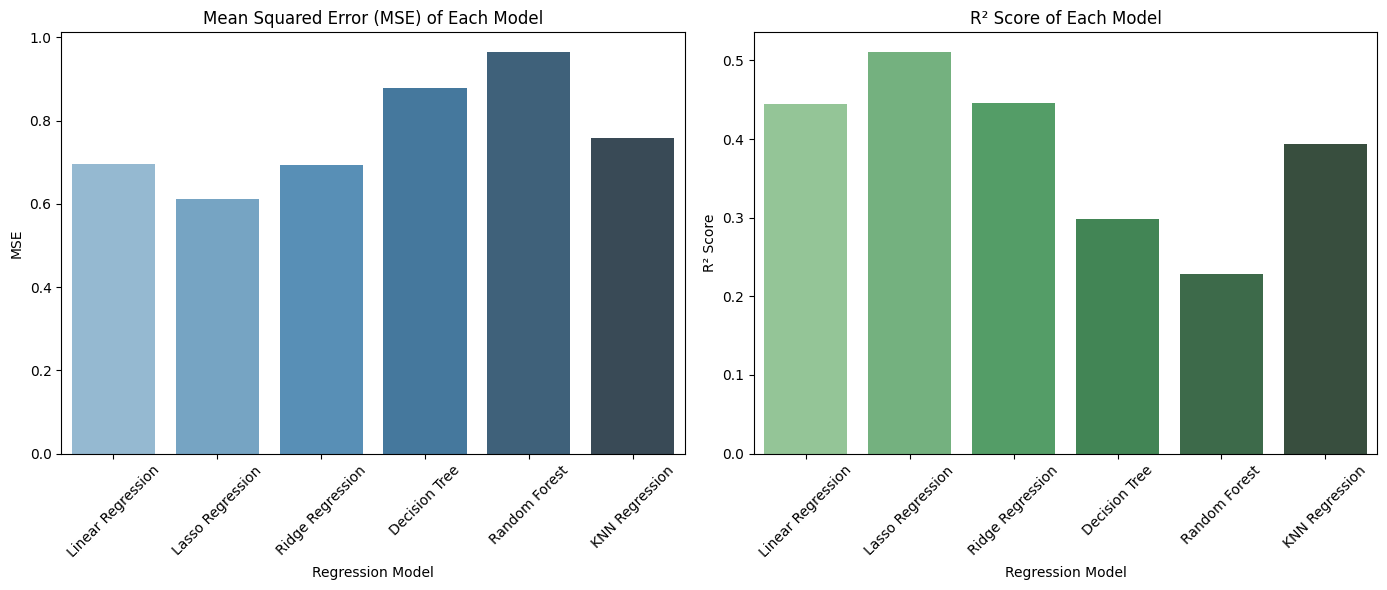

In [61]:
model_names = list(results.keys())
mse_scores = [metrics['MSE'] for metrics in results.values()]
r2_scores = [metrics['R²'] for metrics in results.values()]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for MSE scores
sns.barplot(x=model_names, y=mse_scores, ax=axes[0], palette="Blues_d")
axes[0].set_title("Mean Squared Error (MSE) of Each Model")
axes[0].set_xlabel("Regression Model")
axes[0].set_ylabel("MSE")
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

# Bar plot for R² scores
sns.barplot(x=model_names, y=r2_scores, ax=axes[1], palette="Greens_d")
axes[1].set_title("R² Score of Each Model")
axes[1].set_xlabel("Regression Model")
axes[1].set_ylabel("R² Score")
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

# Adjust layout for a cleaner look
plt.tight_layout()
plt.show()

#### The best model is one with Leat MSE error and Highest R2 score.

#### So, from graphs Lasso Regression model is the Best model with least MSE score and highest R2 score.

# Residual Plots for Each Regression

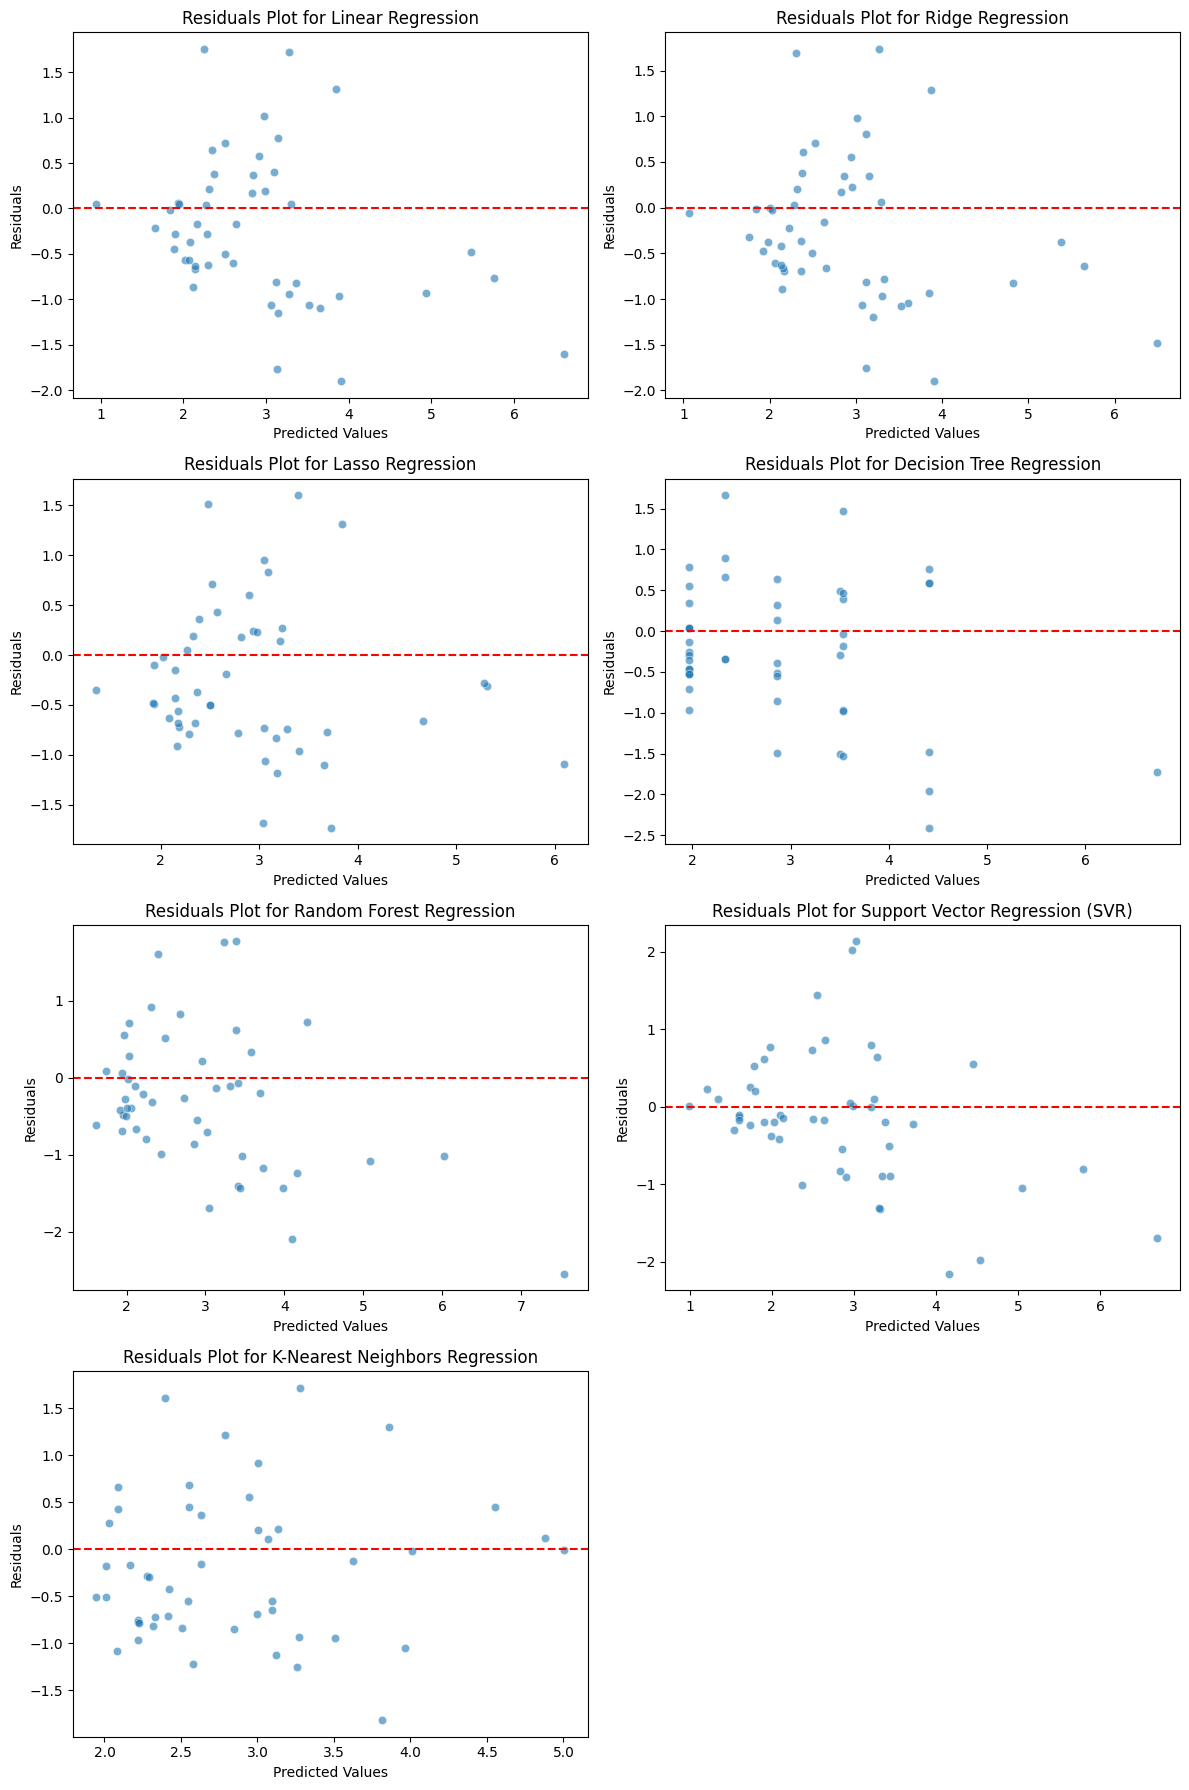

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_residuals(y_test, y_pred, model_name, ax):
    residuals = y_test - y_pred
    sns.scatterplot(x=y_pred, y=residuals, ax=ax, alpha=0.6)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Residuals")
    ax.set_title(f"Residuals Plot for {model_name}")

# Create a 4x2 grid of subplots (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(12, 18))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# 1. Linear Regression
y_pred_lr = lin_reg.predict(X_test)
plot_residuals(y_test, y_pred_lr, "Linear Regression", axes[0])

# 2. Ridge Regression
y_pred_ridge = ridge_grid.predict(X_test)
plot_residuals(y_test, y_pred_ridge, "Ridge Regression", axes[1])

# 3. Lasso Regression
y_pred_lasso = lasso_grid.predict(X_test)
plot_residuals(y_test, y_pred_lasso, "Lasso Regression", axes[2])

# 4. Decision Tree Regression
y_pred_tree = tree_grid.predict(X_test)
plot_residuals(y_test, y_pred_tree, "Decision Tree Regression", axes[3])

# 5. Random Forest Regression
y_pred_forest = forest_grid.predict(X_test)
plot_residuals(y_test, y_pred_forest, "Random Forest Regression", axes[4])

# 6. Support Vector Regression
y_pred_svr = svr_grid.predict(X_test)
plot_residuals(y_test, y_pred_svr, "Support Vector Regression (SVR)", axes[5])

# 7. K-Nearest Neighbors Regression
y_pred_knn = knn_reg.predict(X_test)
plot_residuals(y_test, y_pred_knn, "K-Nearest Neighbors Regression", axes[6])

# Hide the last subplot (axes[7]) since we have only 7 models
axes[7].axis('off')

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


# Identifying Features impacting Tip amounts

Identifying coefficients/weights of each feature given by Lasso Regression fit gives us the contribution of that feature in predicting or establishing relationship with target variable. So, identifying impacting factors by analysing weights given by Lasso fit to each feature.

Significant Factors impacting tips:
total_bill    0.761133
size          0.120226
dtype: float64


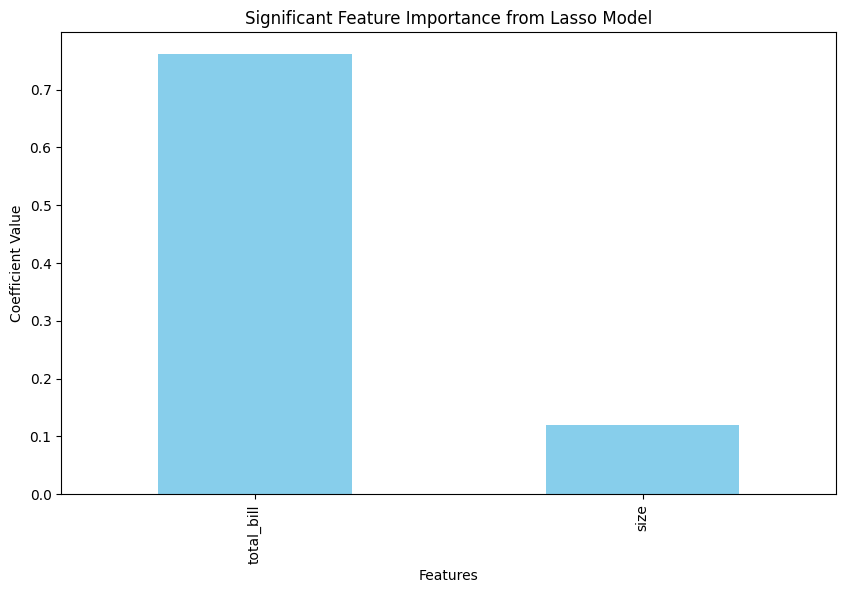

In [52]:
# Initialize and fit the Lasso model
lasso = Lasso(alpha=0.1)  # You can adjust alpha based on your requirements
lasso.fit(X, y)
# Generate feature importance series from Lasso model coefficients
feature_importance = pd.Series(lasso.coef_, index=X.columns)

# Select significant features (non-zero coefficients) and sort by importance
significant_features = feature_importance[feature_importance != 0].sort_values(ascending=False)

# Display significant features if any
if not significant_features.empty:
    print("Significant Factors impacting tips:")
    print(significant_features)

    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    significant_features.plot(kind='bar', color='skyblue')
    plt.title("Significant Feature Importance from Lasso Model")
    plt.xlabel("Features")
    plt.ylabel("Coefficient Value")
    plt.show()
else:
    print("No significant features identified. Consider adjusting the alpha parameter for your Lasso model.")

#### We see that 1) Total Bill and 2) Size (No.of people in a group) are the only features/predictors that significantly impact the tip amount.

#### Even from these 2 predictors, Total Bill is the most impacting Factor in Tip amount.

# Conclusion (Insights for Management)

1) The restaurants should try to provide best services on Weekends (especially on Sunday), as we find that Maximum tip amount is received on sunday, followed by Saturday. Also try to better the quality of service and food on Weekdays like Friday and Thursday to increase the tip amount on these days, which is relatively lower than that on weekends.
2) The restaurants should also focus on Dinner time as it has higher tip rates than during Lunch time.
3) Businesses should serve their best to Larger Group Size of people, as they tend to give slightly more tip.
4) Also, staff should try to impress Male customers as much as possible, as they also tend to tip slightly better than female customers.
5) Restaurants and their staff must be highly careful, while dealing with Customer odering large amount of food, and pay their best service and food quality to them, as Large Total Bill has signicantly high correlation (positive linear dependence) with Tip amount.